## MBA em Ciência de Dados
# Redes Neurais e Arquiteturas Profundas

### <span style="color:darkred">Módulo 7 - Auto-encodes e Redes Geradoras
</span>

#### <span style="color:darkred">**Parte 3: Rede Geradora Adversarial (GAN)**</span>

Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

---

In [1]:
import numpy as np
from numpy.random import seed

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

Vamos projetar uma rede adversária para gerar dados num plano.

Para isso utilizaremos uma função como referência, uma função Senoidal

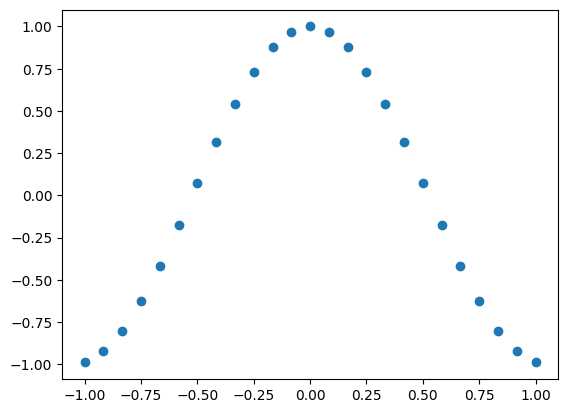

In [2]:
def distribuicao_dados(x):
    return np.cos(x*3)

amostragem = np.linspace(-1.0,1.0,25)
train_ds = [distribuicao_dados(x) for x in amostragem]
plt.plot(amostragem, train_ds, 'o')

In [3]:
# funcao que obtem amostras a partir a distribuicao de dados alvo
def distribuicao_alvo(n=32):
  amost_x = (np.random.rand(n)*2.0)-1.0
  amost_y = np.array([distribuicao_dados(x) for x in amost_x])
  dados_reais = np.stack((amost_x, amost_y),axis=1)
  labels = np.ones((n,1))
  return dados_reais, labels

In [4]:
# funcao que obtem amostras aleatórias no plano
def distribuicao_aleatoria(n=32):
  amost_x = (np.random.rand(n)*2.0)-1.0
  amost_y = (np.random.rand(n)*2.0)-1.0
  dados_aleatorios = np.stack((amost_x, amost_y),axis=1)
  labels = np.zeros((n, 1))
  return dados_aleatorios, labels

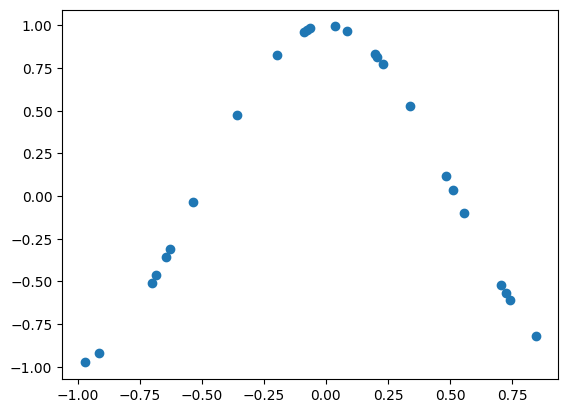

In [5]:
exemplos, labels = distribuicao_alvo(25)
plt.scatter(exemplos[:,0], exemplos[:,1])

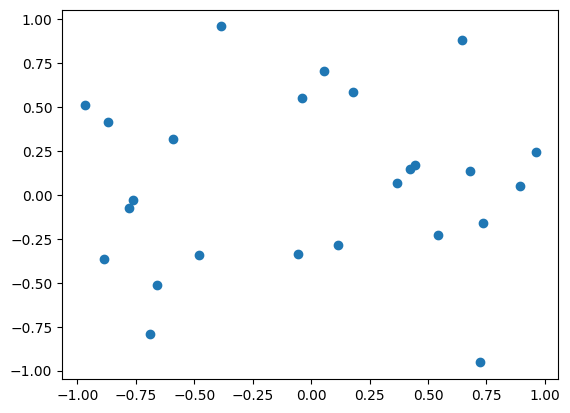

In [6]:
exemplos, labels = distribuicao_aleatoria(25)
plt.scatter(exemplos[:,0], exemplos[:,1])

### Discriminador

Componente que é responsável por identificar se um ponto foi produzido por uma distribuição original ou por outra distribuição.

In [7]:
# modelo discriminador base : classificador
def discriminator(dim_input=2):
    model = models.Sequential()
    model.add(layers.Dense(12, activation='tanh', input_dim=dim_input))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

Para treinar o discriminador, geramos exemplos reais e "falsos" criando rótulos para cada caso

Aqui fazemos um treinamento manual, com metade do batch de cada rótulo.

Não temos ainda uma GAN, aqui o discriminador aprende a classificar entre dados reais e aleatórios, não gerados por outra rede neural

In [21]:
# funcao de ajuste do discriminador
def fit_discriminator(model, epochs=100, batch_size=32, verbose=False):

    histR = np.zeros(epochs)
    histF = np.zeros(epochs)
    for i in range(epochs):
        x_real, y_real = distribuicao_alvo(batch_size//2)
        # treina modelo em meio batch
        model.train_on_batch(x_real, y_real)

        # gera exemplos falsos
        x_falso, y_falso = distribuicao_aleatoria(batch_size//2)
        # treina modelo em meio batch
        model.train_on_batch(x_falso, y_falso)
        loss_real, acc_real = model.evaluate(x_real, y_real, verbose=0)
        loss_falso, acc_falso = model.evaluate(x_falso, y_falso, verbose=0)
        histR[i] = loss_real
        histF[i] = loss_falso
        if (verbose):
          print("Epoch: %d, Accuracy- real: %.2f falso: %.2f" % (i, acc_real, acc_falso))

    return histR, histF

In [9]:
# define the discriminator model
model = discriminator()
model.summary()
# fit the model
histR, histF = fit_discriminator(model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                36        
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


Exibindo os gráficos da perda computada nos exemplos reais e aleatórios, fica claro como raramente elas vão bem ao mesmo tempo

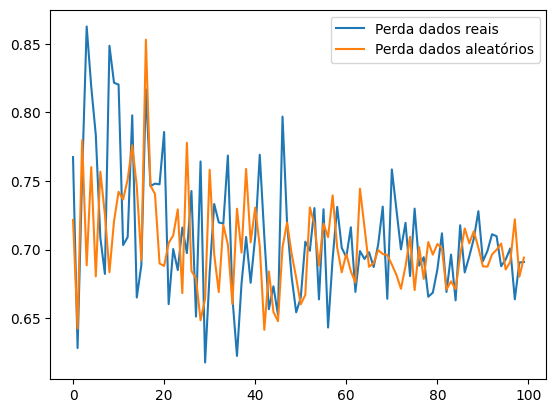

In [10]:
plt.plot(histR)
plt.plot(histF)
plt.legend(['Perda dados reais', 'Perda dados aleatórios'])

### Gerador

Modelo que, a partir de uma amostra da distribuição latente, aprende uma transformação desse em um exemplo candidato à distribuição alvo


In [11]:
# modelo gerador, cuja entrada tem dimensão do espaço latente
# sua saída tem dimensão igual a dos exemplos da distribuição alvo
def generator(z_dim, dim_output=2):
  model = models.Sequential()
  model.add(layers.Dense(10, activation='tanh', input_dim=z_dim))
  model.add(layers.Dense(dim_output, activation='linear'))
  return model

# funcao para gerar uma amostra com n exemplos da distribuicao latente
def amostra_distribuicao_latente(z_dim, n):
  exemplos_z = np.random.randn(z_dim * n)
  return exemplos_z.reshape(n, z_dim)

# funcao para gerar exemplos "falsos", aleatorios a partir da
# saída do gerador G(z)
def gera_exemplos_falsos(model_g, z_dim, n):
  exemplos_z = amostra_distribuicao_latente(z_dim, n)
  exemplos_falsos = model_g.predict(exemplos_z)
  labels_falsos = np.zeros((n,1))
  return exemplos_falsos, labels_falsos

1/1 [==============================] - 0s 98ms/step


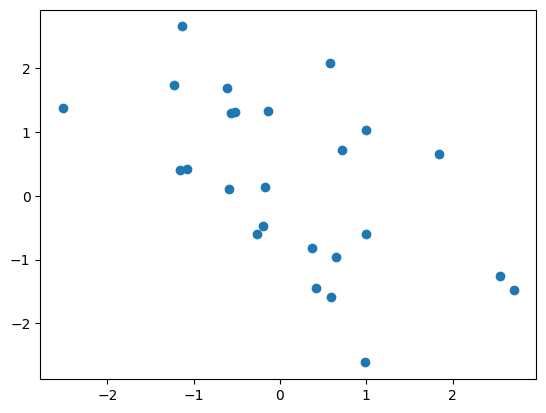

In [13]:
# gerador com dimensionalidade latente = 6
model_gen = generator(6)
# exemplos a partir do gerador aleatório (inicial)
exemplos_falsos, lab_falsos = gera_exemplos_falsos(model_gen, 6, 25)
plt.scatter(exemplos_falsos[:,0],exemplos_falsos[:,1])

### GAN

Tendo os dois componentes, vamos conectá-los para treinamento em conjunto, de forma adversarial

A GAN terá por objetivo treinar o **gerador** enquanto o *discriminador* será treinado de forma independente, e alternada.

In [14]:
def GAN(model_gen, model_dis):
    # o discriminador sera treinado separadamente, entao marcamos como
    # nao treinável dentro desse modelo
    model_dis.trainable = False

    # criamos modelo que gera exemplos, depois os passa ao discriminador
    model_gan = models.Sequential()
    model_gan.add(model_gen)
    model_gan.add(model_dis)
    model_gan.compile(loss='binary_crossentropy',
                      optimizer=keras.optimizers.Adam(learning_rate=0.001),
                      metrics=['accuracy'])
    return model_gan

A função para treinamento da GAN alterna treinamento do *discriminador*, por meio de exemplos falsos e verdadeiros gerados, seguido do treinamento do **gerador** o qual será otimizado para ganhar do discriminador.

In [28]:
def fit_GAN(model_gen, model_dis, model_GAN, z_dim, epochs=200, batch_size=32, verbose=False):
    histR = np.zeros(epochs)
    histF = np.zeros(epochs)
    for i in range(epochs):
        # treinamento do discriminador
        # amostra exemplos para o discriminador
        x_real, y_real = distribuicao_alvo(batch_size//2)
        x_falso, y_falso = gera_exemplos_falsos(model_gen, z_dim, batch_size//2)
        # treina modelo em meio batch
        model_dis.train_on_batch(x_real, y_real)
        model_dis.train_on_batch(x_falso, y_falso)

        # treinamento do gerador
        # exemplos da distribuicao latente
        z_batch = amostra_distribuicao_latente(z_dim, batch_size)
        # invertemos os labels aqui para treinar de forma a enganar o discriminador
        z_labels = np.ones((batch_size,1))
        model_GAN.train_on_batch(z_batch, z_labels)

        # avalia modelo discriminador atual
        loss_real, acc_real = model_dis.evaluate(x_real, y_real, verbose=0)
        loss_falso, acc_falso = model_dis.evaluate(x_falso, y_falso, verbose=0)
        histR[i] = loss_real
        histF[i] = loss_falso
        if (verbose):
            print("Epoch: %d, Accuracy- real: %.2f falso: %.2f" % (i, acc_real, acc_falso))

---
Vamos agora treinar a GAN

Escolhemos uma dimensionalidade latente de forma que $z \in R^4$

4/4 [==============================] - 0s 3ms/step


Text(0.5, 1.0, 'Antes do treinamento')

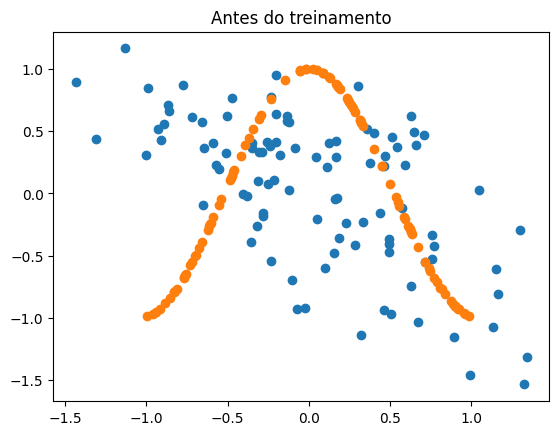

In [16]:
z_dim = 4
model_dis = discriminator()
model_gen = generator(z_dim)

x_falso, y_falso = gera_exemplos_falsos(model_gen, z_dim, 100)
x_real, y_real = distribuicao_alvo(100)

plt.scatter(x_falso[:,0],x_falso[:,1])
plt.scatter(x_real[:,0],x_real[:,1]); plt.title('Antes do treinamento')

In [29]:
model_GAN = GAN(model_gen, model_dis)

fit_GAN(model_gen, model_dis, model_GAN, z_dim, 100, 32, verbose=True)

1/1 [==============================] - 0s 23ms/step
Epoch: 0, Accuracy- real: 1.00 falso: 0.00
1/1 [==============================] - 0s 22ms/step
Epoch: 1, Accuracy- real: 1.00 falso: 0.00
1/1 [==============================] - 0s 25ms/step
Epoch: 2, Accuracy- real: 1.00 falso: 0.00
1/1 [==============================] - 0s 25ms/step
Epoch: 3, Accuracy- real: 1.00 falso: 0.00
1/1 [==============================] - 0s 26ms/step
Epoch: 4, Accuracy- real: 1.00 falso: 0.00
1/1 [==============================] - 0s 29ms/step
Epoch: 5, Accuracy- real: 1.00 falso: 0.00
1/1 [==============================] - 0s 22ms/step
Epoch: 6, Accuracy- real: 1.00 falso: 0.00
1/1 [==============================] - 0s 22ms/step
Epoch: 7, Accuracy- real: 1.00 falso: 0.00
1/1 [==============================] - 0s 23ms/step
Epoch: 8, Accuracy- real: 1.00 falso: 0.00
1/1 [==============================] - 0s 35ms/step
Epoch: 9, Accuracy- real: 1.00 falso: 0.00
1/1 [==============================] - 0s 23ms/ste

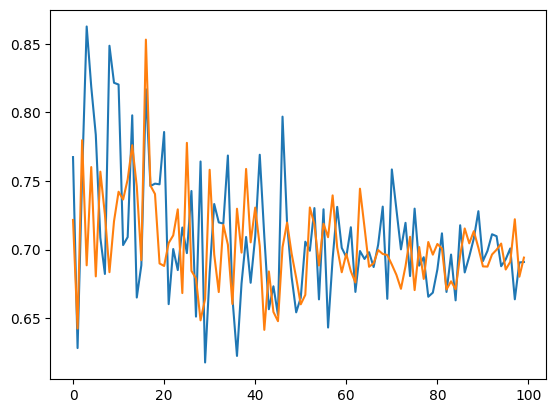

In [24]:
plt.plot(histR)
plt.plot(histF)

7/7 [==============================] - 0s 2ms/step


Text(0.5, 1.0, 'Após 200 épocas')

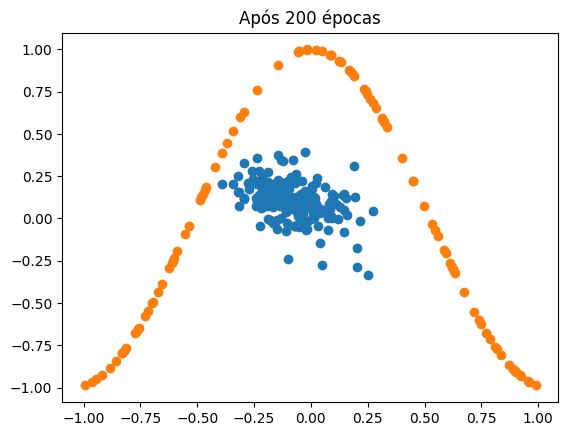

In [25]:
x_falso, y_falso = gera_exemplos_falsos(model_gen, z_dim, 200)
plt.scatter(x_falso[:,0],x_falso[:,1])
plt.scatter(x_real[:,0],x_real[:,1]); plt.title('Após 200 épocas')

In [26]:
fit_GAN(model_gen, model_dis, model_GAN, z_dim, 2800, 32, verbose=False)

1/1 [==============================] - 0s 33ms/step


KeyboardInterrupt: ignored

4/4 [==============================] - 0s 3ms/step


Text(0.5, 1.0, 'Após 3000 épocas')

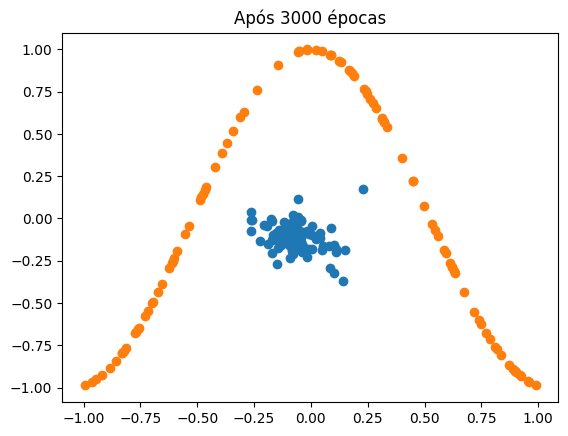

In [27]:
x_falso, y_falso = gera_exemplos_falsos(model_gen, z_dim, 100)
plt.scatter(x_falso[:,0],x_falso[:,1])
plt.scatter(x_real[:,0],x_real[:,1]); plt.title('Após 3000 épocas')

In [ ]:
fit_GAN(model_gen, model_dis, model_GAN, z_dim, 3000, 32, verbose=False)

Text(0.5, 1.0, 'Após 6000 épocas')

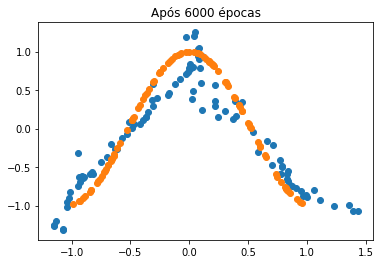

In [ ]:
x_falso, y_falso = gera_exemplos_falsos(model_gen, z_dim, 100)
plt.scatter(x_falso[:,0],x_falso[:,1])
plt.scatter(x_real[:,0],x_real[:,1]); plt.title('Após 6000 épocas')

In [ ]:
fit_GAN(model_gen, model_dis, model_GAN, z_dim, 4000, 32, verbose=False)

Text(0.5, 1.0, 'Após 10000 épocas')

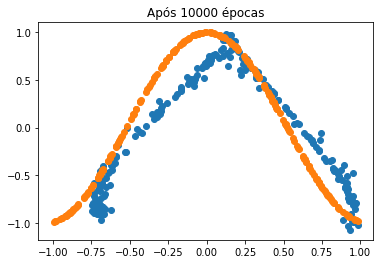

In [ ]:
x_falso, y_falso = gera_exemplos_falsos(model_gen, z_dim, 250)
x_real, y_real = distribuicao_alvo(250)
plt.scatter(x_falso[:,0],x_falso[:,1])
plt.scatter(x_real[:,0],x_real[:,1]); plt.title('Após 10000 épocas')